## Objective

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience

###### Data Profiling
<br>
<br>

**RATING FILE DESCRIPTION**
<br>
All ratings are contained in the file "ratings.dat" and are in the following format: <br>

UserID::MovieID::Rating::Timestamp <br>
UserIDs range between 1 and 6040 <br>
MovieIDs range between 1 and 3952 <br>
Ratings are made on a 5-star scale (whole-star ratings only) <br>
Timestamp is represented in seconds <br>

Each user has at least 20 ratings <br>
<br>
<br>
<br>

**USERS FILE DESCRIPTION**
<br>
User information is in the file "users.dat" and is in the following format: <br>
UserID::Gender::Age::Occupation::Zip-code <br>

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female <br>
Age is chosen from the following ranges: <br>

1: "Under 18"
18: "18-24"
25: "25-34"
35: "35-44"
45: "45-49"
50: "50-55"
56: "56+"
<br>
<br>
Occupation is chosen from the following choices: <br>

0: "other" or not specified
1: "academic/educator"
2: "artist"
3: "clerical/admin"
4: "college/grad student"
5: "customer service"
6: "doctor/health care"
7: "executive/managerial"
8: "farmer"
9: "homemaker"
10: "K-12 student"
11: "lawyer"
12: "programmer"
13: "retired"
14: "sales/marketing"
15: "scientist"
16: "self-employed"
17: "technician/engineer"
18: "tradesman/craftsman"
19: "unemployed"
20: "writer"
<br>
<br>
<br>


**MOVIES FILE DESCRIPTION** <br>

Movie information is in the file "movies.dat" and is in the following format:
<br>
MovieID::Title::Genres
<br>
Titles are identical to titles provided by the IMDB (including year of release)
<br>
Genres are pipe-separated and are selected from the following genres:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western



#####  Concept used:
- Recommender Engine
- Collaborative Filtering (Item-based & User-based Approach)
- Pearson Correlation
- Nearest Neighbors using Cosine Similarity
- Matrix Factorization

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
movies = pd.read_fwf('./movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('./ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('./users.dat', encoding='ISO-8859-1')

In [3]:
print(movies.info())
print('*************************************************************************')
print(users.info())
print('*************************************************************************')
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB
None
*************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB
None
*************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 t

### Data Cleaning & Feature Engineering

In [4]:
# splitting data to create  columns
users = users["UserID::Gender::Age::Occupation::Zip-code"].str.split('::', expand = True)
users.columns = ['UserID','Gender','Age','Occupation','Zip-code']

movies = movies["Movie ID::Title::Genres"].str.split("::", expand = True)
movies.columns = ['Movie ID','Title','Genres']

ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split("::", expand = True)
ratings.columns = ['UserID', 'MovieID','Rating','Timestamp']

In [5]:
movies['Movie ID'] = movies['Movie ID'].astype('int')

users['UserID'] = users['UserID'].astype('int')
users['Age'] = users['Age'].astype('int')
users['Occupation'] = users['Occupation'].astype('int')
users['Gender'] = users['Gender'].map({'F':1,'M':0})
# users['Zip-code'] = users['Zip-code'].astype('int')


ratings['UserID'] = ratings['UserID'].astype('int')
ratings['MovieID'] = ratings['MovieID'].astype('int')
ratings['Timestamp'] = ratings['Timestamp'].astype('int')
ratings['Rating'] = ratings['Rating'].astype('int')


In [6]:
# generating new feature 'Release year'
moo = movies['Title'].str.extract(pat = '(\([0-9]{4}\))').fillna('(0)') # filling missing years with 0
movies['release_year'] = moo[0].str.extract(pat = '([0-9]{4})').fillna(0).astype('int') # removing parenthesis

# filling null values in genres with unknown
movies['Genres'] = movies['Genres'].fillna('Unknown')

In [7]:
# converting the zip code to integer type in users table

zcodes = users.loc[users['Zip-code'].apply(lambda x: len(x) != 5)]['Zip-code'].unique()
zcodes_new = [''.join(item.split('-')) for item in zcodes]
# creating dictionary for the replacement of these values
di = {}
for i in range(len(zcodes)):
    di[zcodes[i]] = zcodes_new[i]
    
# using replace in the main df
users.replace({'Zip-code': di}, inplace =True)
users['Zip-code'] = users['Zip-code'].astype('int')


### Structure and characterstics of dataset

In [8]:
from datetime import datetime as dt
ratings['hour'] = ratings['Timestamp'].apply(lambda x: dt.fromtimestamp(x).hour)
ratings.drop('Timestamp', axis = 1, inplace = True)
ratings.head()

,UserID,MovieID,Rating,hour
0,1,1193,5,3
1,1,661,3,4
2,1,914,3,4
3,1,3408,4,3
4,1,2355,5,5


In [9]:
rates = ratings.copy()
rates = rates.merge(pd.DataFrame(rates.groupby('UserID')['Rating'].mean()).rename(columns = {'Rating':'mean_user_rating'}), on = 'UserID')
rates = rates.merge(pd.DataFrame(rates.groupby('MovieID')['Rating'].mean()).rename(columns = {'Rating': 'mean_movie_rating' }), on = 'MovieID')
rates = rates.merge(pd.DataFrame(rates.groupby('MovieID')['Rating'].count()).rename(columns = {'Rating': 'count_rating_for_movie'}), on = 'MovieID')

In [10]:
# checkin if a user has rated a movie multiple times
r_df = rates.groupby(['UserID','MovieID']).aggregate(np.max)
print(len(r_df))
if (len(r_df) == rates.shape[0]):
    print("There is no such case of repetitive rating by a user")

1000209
There is no such case of repetitive rating by a user


######  Most rated movies present in dataset

In [11]:
top_10_most_rated_movies = rates['MovieID'].value_counts().index.to_list()[:10]
movies[movies['Movie ID'].isin(top_10_most_rated_movies)]

,Movie ID,Title,Genres,release_year
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1977
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1993
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,1991
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,1991
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adv,1980
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventu,1983
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,1985
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1998
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
2789,2858,American Beauty (1999),Comedy|Drama,1999


###### Cosolidating  all tables into one single dataframe

In [12]:
df = users.merge(rates, on = 'UserID').merge(movies, left_on = 'MovieID', right_on = 'Movie ID').drop('Movie ID', axis = 1)  
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,hour,mean_user_rating,mean_movie_rating,count_rating_for_movie,Title,Genres,release_year
0,1,1,1,10,48067,1193,5,3,4.188679,4.390725,1725,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,2,0,56,16,70072,1193,5,3,3.713178,4.390725,1725,One Flew Over the Cuckoo's Nest (1975),Drama,1975
2,12,0,25,12,32793,1193,4,5,3.826087,4.390725,1725,One Flew Over the Cuckoo's Nest (1975),Drama,1975
3,15,0,25,7,22903,1193,4,23,3.323383,4.390725,1725,One Flew Over the Cuckoo's Nest (1975),Drama,1975
4,17,0,50,1,95350,1193,5,12,4.075829,4.390725,1725,One Flew Over the Cuckoo's Nest (1975),Drama,1975


For the ease of computation we'll consider data with only the movies (1000) that have most rate count.

In [13]:
c = df[['MovieID','count_rating_for_movie']].sort_values(['count_rating_for_movie'],ascending = False).drop_duplicates()[:1000] 
selected_movies = c['MovieID']

In [14]:
df1 = df[df['MovieID'].isin(selected_movies)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747869 entries, 0 to 958430
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  747869 non-null  int32  
 1   Gender                  747869 non-null  int64  
 2   Age                     747869 non-null  int32  
 3   Occupation              747869 non-null  int32  
 4   Zip-code                747869 non-null  int32  
 5   MovieID                 747869 non-null  int32  
 6   Rating                  747869 non-null  int32  
 7   hour                    747869 non-null  int64  
 8   mean_user_rating        747869 non-null  float64
 9   mean_movie_rating       747869 non-null  float64
 10  count_rating_for_movie  747869 non-null  int64  
 11  Title                   747869 non-null  object 
 12  Genres                  747869 non-null  object 
 13  release_year            747869 non-null  int32  
dtypes: float64(2), int32

Creating features for movies as per genres into distinct columns

In [15]:
m = movies.copy()
m = movies[movies['Movie ID'].isin(selected_movies)]

m['Genres'] = m['Genres'].str.split('|')
m = m.explode('Genres')
m = m.pivot(index = 'Movie ID', columns = 'Genres', values = 'Title')
m = ~m.isna()
m = m.astype('int')

C:\Users\A Singh\AppData\Local\Temp\ipykernel_11168\803360873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['Genres'] = m['Genres'].str.split('|')


In [16]:
m['action'] = m['A'] + m['Action'] 
m.drop(['A','Action'], axis = 1, inplace = True)

m['animation'] =m['Animation'] 
m.drop(['Animation'], axis = 1, inplace = True)

m['adventure'] = m['Adv'] + m['Adventu'] +m['Adventur'] + m['Adventure']
m.drop(['Adv','Adventu','Adventur','Adventure'], axis = 1, inplace = True)

m['romance'] = m['R'] + m['Ro']+m['Romance'] 
m.drop(['R','Ro','Romance'], axis = 1, inplace = True)

m['children'] = m["Children'"] + m["Children's"] 
m.drop(["Children'","Children's"], axis = 1, inplace = True)

m['comedy']  = m['Comedy']
m.drop(['Comedy'], axis = 1, inplace = True)

m['crime'] = m['Crime']
m.drop(['Crime'], axis = 1, inplace = True)

m['documentary']  = m['D'] + m['Documentary']
m.drop(['D','Documentary'], axis = 1, inplace = True)

m['film-noir'] =  m['Film-Noir']
m.drop(['Film-Noir'], axis = 1, inplace = True)

m['drama'] = m['Dr'] + m['Dram'] + m['Drama']
m.drop(['Dr','Dram','Drama'], axis = 1, inplace = True)

m['fantasy'] = m['Fant'] + m['Fantas'] + m['Fantasy']
m.drop(['Fant','Fantas','Fantasy'], axis = 1, inplace = True)

m['horror'] = m['Horro'] + m['Horror']
m.drop(['Horro','Horror'], axis = 1, inplace = True)

m['musical'] = m['Music'] + m['Musical']
m.drop(['Music','Musical'], axis = 1, inplace = True)

m['mystery'] = m['Mystery']
m.drop(['Mystery'], axis= 1, inplace = True)

m['sci-fi'] = m['S'] + m['Sci'] + m['Sci-F'] + m['Sci-Fi'] + m['Sci-']
m.drop(['S','Sci','Sci-F','Sci-Fi','Sci-'], axis = 1, inplace = True)

m['thriller'] = m['Th'] + m['Thriller'] 
m.drop(['Th','Thriller'], axis = 1, inplace = True)

m['western'] = m['Wester'] + m['Western']
m.drop(['Western','Wester'], axis = 1, inplace =True)

m['war'] = m['War'] 
m.drop(['War'], axis = 1, inplace = True)

m['unknown'] = m[''] + m['Unknown']
m.drop(['Unknown',''], axis = 1, inplace = True)

In [17]:
# m = m.reset_index()

In [18]:
m.columns

Index(['action', 'animation', 'adventure', 'romance', 'children', 'comedy',
       'crime', 'documentary', 'film-noir', 'drama', 'fantasy', 'horror',
       'musical', 'mystery', 'sci-fi', 'thriller', 'western', 'war',
       'unknown'],
      dtype='object', name='Genres')

### EDA

###### Genres distribution

In [19]:
gen = {}

for col in m.columns:
    gen[col] = m[col].sum()

gen1 = list(gen.keys())
gen_count1 = list(gen.values())
gen_df = pd.DataFrame(columns = ['gen','gen_count'])
gen_df['gen'] = gen1
gen_df['gen_count'] = gen_count1
gen_df = gen_df.sort_values('gen_count', ascending = False)

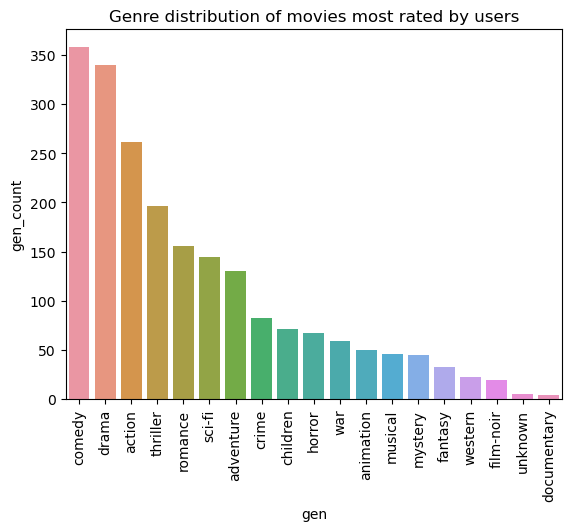

In [20]:
sns.barplot(data = gen_df, x = gen_df['gen'], y = gen_df['gen_count'])
plt.xticks(rotation = 90)
plt.title('Genre distribution of movies most rated by users')
plt.show()

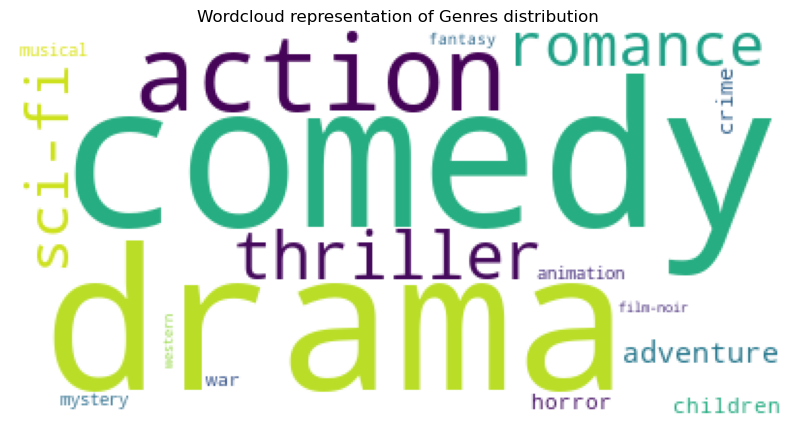

In [21]:
plt.figure(figsize = (10,8))
wordcloud = WordCloud(width=400, height=200, background_color = 'white', min_font_size=7).generate_from_frequencies(gen)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud representation of Genres distribution')
plt.show()

In [22]:
# merging with main df
m = m.reset_index()
df2 = df1.merge(m, left_on = 'MovieID', right_on = 'Movie ID')

In [23]:
df2.drop(['Genres','Movie ID'], axis = 1, inplace = True)

In [24]:
print(df2.shape)
df2.info()

(747869, 32)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 747869 entries, 0 to 747868
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  747869 non-null  int32  
 1   Gender                  747869 non-null  int64  
 2   Age                     747869 non-null  int32  
 3   Occupation              747869 non-null  int32  
 4   Zip-code                747869 non-null  int32  
 5   MovieID                 747869 non-null  int32  
 6   Rating                  747869 non-null  int32  
 7   hour                    747869 non-null  int64  
 8   mean_user_rating        747869 non-null  float64
 9   mean_movie_rating       747869 non-null  float64
 10  count_rating_for_movie  747869 non-null  int64  
 11  Title                   747869 non-null  object 
 12  release_year            747869 non-null  int32  
 13  action                  747869 non-null  int32  
 14  animati

##### User of which age group have watched and rated the most number of movies?

In [25]:
q_df = df2[['UserID','Age','Rating','MovieID']]

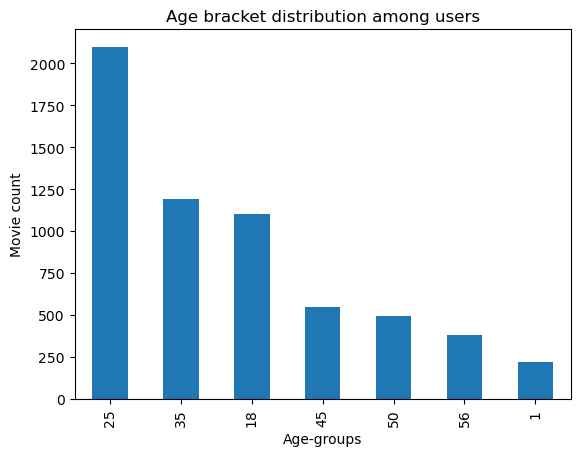

In [26]:
users['Age'].value_counts().plot(kind = 'bar')
plt.title('Age bracket distribution among users')
plt.xlabel('Age-groups')
plt.ylabel('Movie count')
plt.show()

Age group: 25 watches most number of movies. This group belong to people who are aged between 25 -34.

##### Users belonging to which profession have watched and rated the most movies?

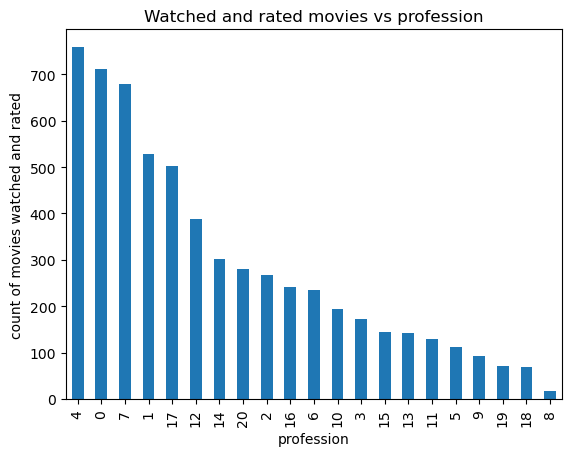

In [28]:
users['Occupation'].value_counts().plot(kind = 'bar')
plt.title('Watched and rated movies vs profession')
plt.xlabel('profession')
plt.ylabel('count of movies watched and rated')
plt.show()

People who belong to occupation :  4 and 0 watches almost equally. These profession belong to college/grad student and other/NA category.

##### Most of the users in our dataset who’ve rated the movies are Male?

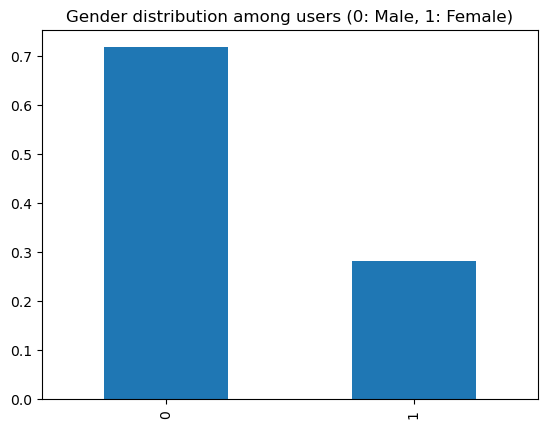

In [29]:
users['Gender'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Gender distribution among users (0: Male, 1: Female)')
plt.show()

There are around 70% males and approx. 30% females who seems to be interested in the content.

##### Most of the movies present in our dataset were released in which decade? <br>
##### a. 70s b. 90s c. 50s d.80s

In [30]:
def dec_release(year):
    if year >= 1970 and year <1980:
        year = "70's"
    elif year >= 1980 and year < 1990:
        year = "80's"
    elif year >= 1990 and year < 2000:
        year = "90's"
    elif year >= 1950 and year < 1960:
        year = "50's"
    else:
        year = 'other'
    return year
    

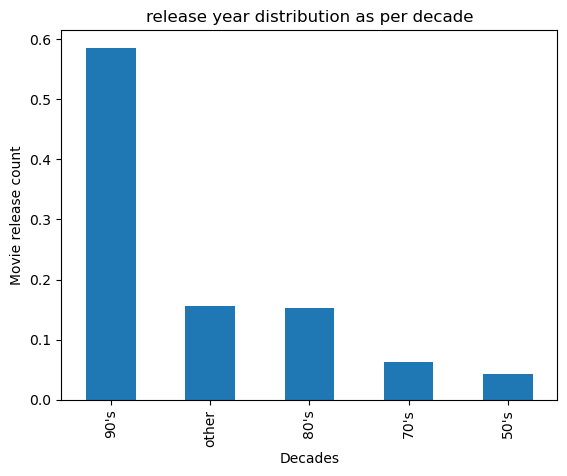

In [31]:
q_df = movies.copy()
q_df.columns
# plot
q_df['release_year'].apply(dec_release).value_counts(normalize = True).plot(kind = 'bar')
plt.title('release year distribution as per decade')
plt.xlabel('Decades')
plt.ylabel('Movie release count')
plt.show()

Around 57% of movies in the dataset released in 90's, followed by 80's.

##### The movie with maximum no. of ratings

In [32]:
df2[['count_rating_for_movie' ]].max()[0]
max_rate_mov_idx = df2.loc[df2['count_rating_for_movie'] == df2[['count_rating_for_movie' ]].max()[0],'MovieID'].unique()[0]
print('count of ratings:', df2[['count_rating_for_movie' ]].max()[0])
movies.loc[movies['Movie ID'] == max_rate_mov_idx]

count of ratings: 3428


,Movie ID,Title,Genres,release_year
2789,2858,American Beauty (1999),Comedy|Drama,1999


The movie 'American Beauty' released in 1999 is most rated movies with  3428. This movies is watched by half of all the unique users.

### Recommendation system based on pearson correlation

In [33]:
c = df2[['Title','UserID','Rating']].drop_duplicates()

# replacing null values with the average rating given by user to a movie
pc_item_matrix2 = c.pivot_table(index = 'UserID', columns = 'Title', values = 'Rating').fillna(0).astype('int')
pc_item_matrix = pc_item_matrix2.corr()

In [34]:
# function that will return 
def correlated_movies(movie_name):
#     m_id = movies.loc[movies['Title'] == movie_name,'Movie ID' ][0]

    if movie_name in pc_item_matrix.index:
        print('Query: movie title: ',movie_name)
        s = pd.DataFrame(pc_item_matrix[movie_name].sort_values(ascending = False)).reset_index().rename(columns = {movie_name: 'pearson_corr'})[:11]    
        return s
    else:
        return 'Movie Id entered is not in the list of top 1000 rated movies'

In [35]:
# Top 10 most similar movies prediction based on user rating.
correlated_movies('Toy Story (1995)')[:7]

Query: movie title:  Toy Story (1995)


,Title,pearson_corr
0,Toy Story (1995),1.000000
1,Toy Story 2 (1999),0.487370
2,Aladdin (1992),0.470753
3,"Lion King, The (1994)",0.411131
4,Groundhog Day (1993),0.407547
5,"Bug's Life, A (1998)",0.402679
6,Beauty and the Beast (1991),0.395510


### Recommender System based on Cosine Similarity.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
# User-User similarity matrix
user_sim_mat_ = cosine_similarity(pc_item_matrix2)
user_sim_mat = pd.DataFrame(user_sim_mat_, index = pc_item_matrix2.index, columns = pc_item_matrix2.index)
user_sim_mat

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.103288,0.127350,0.136598,0.111278,0.211648,0.062388,0.140166,0.239322,0.284641,...,0.199426,0.091620,0.075764,0.040791,0.131553,0.241856,0.151890,0.000000,0.194863,0.162558
2,0.103288,1.000000,0.161165,0.177878,0.142268,0.120023,0.322113,0.230697,0.202814,0.261179,...,0.132526,0.102693,0.293707,0.017443,0.209512,0.285439,0.232169,0.073721,0.080170,0.264001
3,0.127350,0.161165,1.000000,0.154835,0.077085,0.087467,0.143572,0.086808,0.132860,0.242355,...,0.107892,0.139606,0.174027,0.000000,0.108277,0.184619,0.119485,0.132086,0.112529,0.160848
4,0.136598,0.177878,0.154835,1.000000,0.053969,0.015492,0.132125,0.110115,0.096101,0.133765,...,0.185487,0.100795,0.402865,0.000000,0.091162,0.214701,0.138060,0.067499,0.075032,0.162792
5,0.111278,0.142268,0.077085,0.053969,1.000000,0.065027,0.153176,0.272018,0.316964,0.153194,...,0.136554,0.046329,0.077847,0.076149,0.226796,0.356759,0.220808,0.026272,0.038469,0.305988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.241856,0.285439,0.184619,0.214701,0.356759,0.128634,0.156219,0.291807,0.307554,0.431181,...,0.187326,0.258701,0.240220,0.125354,0.332055,1.000000,0.427238,0.140983,0.264418,0.484882
6037,0.151890,0.232169,0.119485,0.138060,0.220808,0.081596,0.122613,0.170756,0.247019,0.296280,...,0.166677,0.310575,0.148169,0.151128,0.170399,0.427238,1.000000,0.056964,0.304871,0.534097
6038,0.000000,0.073721,0.132086,0.067499,0.026272,0.080738,0.000000,0.022542,0.102914,0.135267,...,0.132381,0.124257,0.045947,0.000000,0.076214,0.140983,0.056964,1.000000,0.175649,0.100987


##### Item-Item similairity

In [38]:
item_sim_mat_ = cosine_similarity(pc_item_matrix2.T)
item_sim_mat = pd.DataFrame(item_sim_mat_, index = (pc_item_matrix.T).index, columns =(pc_item_matrix.T).index )

In [39]:
# function that will return 
def sim_movies(movie_name):
#     m_id = movies.loc[movies['Title'] == movie_name,'Movie ID' ][0]
    if movie_name in pc_item_matrix.index:
        
        s = pd.DataFrame(item_sim_mat[movie_name].sort_values(ascending = False)).reset_index().rename(columns = {movie_name: 'cosine_sim'})[:11]    
        return s
    else:
        return 'Movie Id entered is not in the list of top 1000 rated movies'

In [40]:
sim_movies('Toy Story (1995)')[:6]

,Title,cosine_sim
0,Toy Story (1995),1.000000
1,Toy Story 2 (1999),0.633104
2,Groundhog Day (1993),0.610826
3,Aladdin (1992),0.605849
4,"Bug's Life, A (1998)",0.579382
5,Back to the Future (1985),0.570125


##### Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [41]:
import re
movies[movies['Title'].apply(lambda x: (len(re.findall(r'(Liar Liar)',x))> 0))]

,Movie ID,Title,Genres,release_year
1455,1485,Liar Liar (1997),Comedy,1997


In [42]:
# top 3 movies similar to the queried movie as per cosine similarity
sim_movies('Liar Liar (1997)')[:4]

,Title,cosine_sim
0,Liar Liar (1997),1.000000
1,Mrs. Doubtfire (1993),0.557067
2,Ace Ventura: Pet Detective (1994),0.516861
3,Dumb & Dumber (1994),0.512585


In [43]:
# Top 10 most similar movies prediction based on user rating.
correlated_movies('Liar Liar (1997)')[:4]

Query: movie title:  Liar Liar (1997)


,Title,pearson_corr
0,Liar Liar (1997),1.000000
1,Mrs. Doubtfire (1993),0.499927
2,Dumb & Dumber (1994),0.459601
3,Ace Ventura: Pet Detective (1994),0.458654


Both the recommendation system are giving similar results.
As per the item based approach we get there movies as : Mrs. Doubtfire (1993)',Ace Ventura: Pet Detective (1994), and Dumb & Dumber (1994).

### Recommendation System based on KNN

In [44]:
df2.columns

Index(['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code', 'MovieID',
       'Rating', 'hour', 'mean_user_rating', 'mean_movie_rating',
       'count_rating_for_movie', 'Title', 'release_year', 'action',
       'animation', 'adventure', 'romance', 'children', 'comedy', 'crime',
       'documentary', 'film-noir', 'drama', 'fantasy', 'horror', 'musical',
       'mystery', 'sci-fi', 'thriller', 'western', 'war', 'unknown'],
      dtype='object')

In [45]:
f_ratings = df2[['MovieID','UserID','Rating','mean_movie_rating','count_rating_for_movie']].drop_duplicates()
f_movie = f_ratings.pivot(index = 'MovieID', columns = 'UserID', values = 'Rating').fillna(0)

In [46]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(metric = 'cosine')
knn_model.fit(f_movie)

NearestNeighbors(metric='cosine')

In [47]:
t = df2[['MovieID']].drop_duplicates()
mov = t.merge(movies[['Movie ID','Title']], left_on = 'MovieID', right_on = 'Movie ID').drop('Movie ID', axis = 1)
mov.head()

,MovieID,Title
0,1193,One Flew Over the Cuckoo's Nest (1975)
1,661,James and the Giant Peach (1996)
2,914,My Fair Lady (1964)
3,3408,Erin Brockovich (2000)
4,2355,"Bug's Life, A (1998)"


In [48]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(movieid) :
    query_index_movie_ratings = f_movie.loc[movieid,:].values.reshape(1,-1)
    distances,indices = knn_model.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    distances = distances[0]
    indices = indices[0]
    for i in range(0,len(distances)):
        get_movie = mov.loc[mov['MovieID']==movieid]['Title']
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            indices_flat = indices[i]
            get_movie = mov.loc[mov['MovieID']==f_movie.iloc[indices_flat,:].name]['Title']
            print('{0}: {1}:'.format(i,get_movie))

In [49]:
# top 10 recommendations as per KNN using cosine similarity
print_similar_movies(1485)

Recommendations for 232    Liar Liar (1997)
Name: Title, dtype: object:

1: 641    Mrs. Doubtfire (1993)
Name: Title, dtype: object:
2: 492    Ace Ventura: Pet Detective (1994)
Name: Title, dtype: object:
3: 581    Dumb & Dumber (1994)
Name: Title, dtype: object:
4: 431    Home Alone (1990)
Name: Title, dtype: object:
5: 409    Wayne's World (1992)
Name: Title, dtype: object:
6: 394    Wedding Singer, The (1998)
Name: Title, dtype: object:
7: 269    Austin Powers: International Man of Mystery (1...
Name: Title, dtype: object:
8: 242    There's Something About Mary (1998)
Name: Title, dtype: object:
9: 84    League of Their Own, A (1992)
Name: Title, dtype: object:
10: 387    Mask, The (1994)
Name: Title, dtype: object:


For the movie, 'Liar Liar' top 3 recommendation system are similar to earlier recommendation models.

### Recommendation system based on Matrix  Factorization

In [50]:
# pip install cmfrec
from cmfrec import CMF

In [51]:
c2 = df2[['UserID','MovieID','Rating']].drop_duplicates()

In [54]:
rm_raw = c2.copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,2,1193,5


In [55]:
model = CMF(k = 4, verbose = False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [56]:
# user embedding
print('user embedded matrix shape',model.A_.shape)
print()
print(model.A_)
print('*'*70)
# item embedding
print('item embedded matrix shape',model.B_.shape)
print()
print(model.B_)

user embedded matrix shape (6040, 4)

[[-0.09302246  0.09001032  0.05650466 -0.31945166]
 [-0.0363648   0.20171809  0.1284809  -0.53108686]
 [-0.16231604  0.23629466  0.05949501  0.06730203]
 ...
 [ 0.17947267 -0.06120794  0.38607547  0.09880666]
 [-0.17441665 -0.30694023  0.3243508   0.15372099]
 [ 0.08222602  0.26729718 -0.05151986 -0.14159204]]
**********************************************************************
item embedded matrix shape (1000, 4)

[[ 0.7062058   0.52014744  0.82987505  0.34912091]
 [ 0.3263429  -0.38349256  0.48838964  0.34828377]
 [-0.16695572 -0.26817438  0.7613893  -0.90138483]
 ...
 [-0.18255678 -0.1320905  -0.25475064 -1.1082187 ]
 [ 0.42397305  0.41250676 -0.23859079  0.28820723]
 [ 0.81781346 -0.55005664  0.3968498   0.44524837]]


Model performance evaluation

In [57]:
a = model.A_
f = model.B_

In [58]:
print('Mean rating from RATES table',rates['Rating'].mean())
print('global mean from model',model.glob_mean_)

Mean rating from RATES table 3.581564453029317
global mean from model 3.7055768966674805


In [59]:
R_hat = np.dot(model.A_,model.B_.T ) + model.glob_mean_
R_hat.shape 

(6040, 1000)

###### Top N movies that can be recommended to a certain user

In [60]:
top_items = model.topN(user=13, n = 5) # iven userid = 13
# movies recommended for this users
movies.loc[movies['Movie ID'].isin(top_items)]

,Movie ID,Title,Genres,release_year
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1977
315,318,"Shawshank Redemption, The (1994)",Drama,1994
523,527,Schindler's List (1993),Drama|War,1993
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,1981
2693,2762,"Sixth Sense, The (1999)",Thriller,1999


In [62]:
print('Shape of R_hat:',R_hat.shape)
R_hat

Shape of R_hat: (6040, 1000)


array([[3.622067 , 3.5570378, 4.02794  , ..., 4.050297 , 3.597718 ,
        3.4601796],
       [3.7060285, 3.494132 , 4.2340903, ..., 4.2414002, 3.5896518,
        3.3794029],
       [3.7867265, 3.614486 , 3.653942 , ..., 3.6142547, 3.7394345,
        3.496434 ],
       ...,
       [4.155374 , 4.010587 , 3.8969183, ..., 3.4730456, 3.6927826,
        4.083227 ],
       [3.7455866, 3.9783146, 3.9254057, ..., 3.5249767, 3.4719305,
        3.9289336],
       [3.8104916, 3.5554283, 3.7085688, ..., 3.8252983, 3.8221848,
        3.5423045]], dtype=float32)

In [63]:
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

In [64]:
y = list(c2['Rating'])
y_pred = model.predict(rm_raw['UserId'], rm_raw['ItemId'])

print('RMSE error:', MSE(y,y_pred)**0.5)
print('MAPE error:', MAPE(y,y_pred))

RMSE error: 0.8123013933200733
MAPE error: 0.2337505011104012


RMSE and MAPE that you got while evaluating the Matrix Factorization model are 0.812 and 0.2337 respectively.

###### using embedding models

In [65]:
new_d =  pd.DataFrame(R_hat,columns = c2['MovieID'].sort_values().unique(), index = c2['UserID'].sort_values().unique())
new_d

,1,2,3,6,7,10,11,16,17,19,...,3863,3868,3869,3893,3897,3911,3916,3927,3948,3952
1,3.622067,3.557038,4.027940,4.006278,3.891804,3.792079,3.982667,3.767998,3.985321,3.912745,...,3.717987,3.969872,3.694255,3.479898,3.574268,4.010949,3.676220,4.050297,3.597718,3.460180
2,3.706028,3.494132,4.234090,4.240225,3.950349,3.826942,4.161201,3.816159,4.126236,3.984239,...,3.694699,4.164002,3.721573,3.242414,3.526134,4.225148,3.704143,4.241400,3.589652,3.379403
3,3.786726,3.614486,3.653942,3.572187,3.856650,3.871564,4.020273,3.894682,3.726802,3.696937,...,3.572736,3.587072,3.508464,3.546436,3.810726,3.552267,3.533779,3.614255,3.739434,3.496434
4,3.528649,3.343168,3.584125,3.967787,3.506379,3.587076,3.786522,3.560094,3.314733,3.265359,...,3.847868,4.220633,3.513057,3.825866,3.928648,4.476030,3.468346,4.030511,3.864707,3.322983
5,3.645378,3.804606,3.668696,3.530368,3.777065,3.739813,3.626704,3.726034,3.786457,3.836238,...,3.691802,3.485333,3.725834,3.805637,3.641608,3.412895,3.730856,3.570010,3.629890,3.788785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.579920,3.332211,2.900523,3.315475,3.353374,3.619710,3.715795,3.626604,2.740503,2.788311,...,3.740389,3.758767,3.181989,4.163922,4.339311,3.994424,3.173280,3.445663,4.095995,3.285187
6037,3.596031,3.706639,3.549824,3.368647,3.869124,3.841972,3.799502,3.824790,3.727672,3.783811,...,3.634379,3.382689,3.540191,3.825215,3.741686,3.309846,3.552800,3.490178,3.647960,3.591479
6038,4.155374,4.010587,3.896918,3.670450,3.802071,3.802726,3.776045,3.887509,4.019300,3.977391,...,3.503635,3.420356,3.909154,3.296486,3.585392,3.209996,3.971307,3.473046,3.692783,4.083227
6039,3.745587,3.978315,3.925406,3.515261,4.008435,3.868206,3.726146,3.865003,4.201781,4.242421,...,3.592823,3.273571,3.854515,3.583388,3.424230,3.045165,3.883079,3.524977,3.471931,3.928934


item - item similarity matrix

In [66]:
## ITem - ITem similarity  with embeddings
item_sim_mat_e = cosine_similarity(new_d.T)
item_sim_mat_embed = pd.DataFrame(item_sim_mat_e, index = (new_d.T).index, columns =(new_d.T).index )

item_sim_mat_embed# item-similarity matrix with embeddings
item_sim_mat_embed

,1,2,3,6,7,10,11,16,17,19,...,3863,3868,3869,3893,3897,3911,3916,3927,3948,3952
1,1.000000,0.998383,0.993711,0.992045,0.994808,0.996766,0.994938,0.997837,0.993798,0.993836,...,0.992475,0.988661,0.996794,0.987993,0.995552,0.982480,0.997576,0.988332,0.997034,0.997963
2,0.998383,1.000002,0.995627,0.993800,0.996631,0.997740,0.994477,0.998073,0.995922,0.996637,...,0.995784,0.990753,0.999079,0.992818,0.995982,0.984996,0.999435,0.991258,0.997399,0.999499
3,0.993711,0.995627,1.000000,0.998321,0.998300,0.997336,0.996890,0.996828,0.999206,0.998934,...,0.995809,0.995146,0.997762,0.989368,0.991996,0.990699,0.997511,0.997191,0.993758,0.993450
6,0.992045,0.993800,0.998321,0.999999,0.995858,0.995705,0.995460,0.994873,0.995361,0.995161,...,0.997846,0.998987,0.997228,0.992435,0.993967,0.996600,0.996536,0.999286,0.995340,0.992159
7,0.994808,0.996631,0.998300,0.995858,1.000001,0.999563,0.998914,0.999131,0.998699,0.998906,...,0.996185,0.993412,0.996866,0.991918,0.994951,0.988568,0.996827,0.995534,0.995604,0.993663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,0.982480,0.984996,0.990699,0.996600,0.988568,0.989012,0.989361,0.987297,0.985213,0.985333,...,0.995927,0.999197,0.990114,0.992826,0.991586,1.000001,0.988628,0.997803,0.991753,0.983055
3916,0.997576,0.999435,0.997511,0.996536,0.996827,0.997497,0.994753,0.997556,0.996864,0.997305,...,0.996982,0.993640,0.999922,0.992983,0.995480,0.988628,1.000000,0.994134,0.997234,0.998970
3927,0.988332,0.991258,0.997191,0.999286,0.995534,0.994913,0.994981,0.993508,0.994076,0.994093,...,0.997940,0.999313,0.995166,0.993454,0.993166,0.997803,0.994134,1.000000,0.993908,0.988757
3948,0.997034,0.997399,0.993758,0.995340,0.995604,0.997691,0.995850,0.997700,0.992031,0.992656,...,0.997946,0.995175,0.997271,0.996204,0.999722,0.991753,0.997234,0.993908,1.000000,0.996450


User-User similarity matrix

In [67]:
## User-User similarity  with embeddings
user_sim_mat_e = cosine_similarity(new_d)
user_sim_mat_embed = pd.DataFrame(user_sim_mat_e, index = (new_d).index, columns =(new_d).index )

user_sim_mat_embed# item-similarity matrix with embeddings
user_sim_mat_embed

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,0.999213,0.997622,0.997102,0.996120,0.994173,0.996751,0.995311,0.995896,0.996115,...,0.997406,0.994529,0.995837,0.996081,0.993004,0.989104,0.995212,0.993124,0.993055,0.998856
2,0.999213,1.000000,0.994787,0.996207,0.992082,0.991878,0.993330,0.991835,0.992251,0.993089,...,0.994209,0.990618,0.992527,0.992046,0.988740,0.985036,0.990756,0.990009,0.988823,0.997415
3,0.997622,0.994787,1.000000,0.995369,0.998378,0.997026,0.998745,0.997776,0.997071,0.996456,...,0.998098,0.995041,0.998120,0.998015,0.996089,0.994022,0.998928,0.995310,0.995403,0.998667
4,0.997102,0.996207,0.995369,1.000000,0.991955,0.986854,0.997319,0.988570,0.989897,0.997898,...,0.997556,0.995555,0.993389,0.995473,0.987559,0.994844,0.992004,0.986011,0.984909,0.998297
5,0.996120,0.992082,0.998378,0.991955,1.000000,0.995786,0.997720,0.999014,0.999568,0.994905,...,0.997644,0.996567,0.998756,0.998805,0.998819,0.990203,0.999319,0.997312,0.998572,0.996510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.989104,0.985036,0.994022,0.994844,0.990203,0.983841,0.996829,0.985820,0.985952,0.996165,...,0.995407,0.993487,0.991462,0.994653,0.985916,1.000000,0.992766,0.982071,0.981900,0.993672
6037,0.995212,0.990756,0.998928,0.992004,0.999319,0.995750,0.998216,0.998215,0.998026,0.995888,...,0.997770,0.995505,0.997510,0.998519,0.997069,0.992766,1.000000,0.995114,0.997212,0.996006
6038,0.993124,0.990009,0.995310,0.986011,0.997312,0.997162,0.992150,0.998766,0.998270,0.986490,...,0.991477,0.990626,0.997937,0.993772,0.999206,0.982071,0.995114,1.000000,0.998187,0.993830
6039,0.993055,0.988823,0.995403,0.984909,0.998572,0.996440,0.992801,0.999380,0.999372,0.988783,...,0.992860,0.991435,0.996292,0.994843,0.998637,0.981900,0.997212,0.998187,1.000000,0.992167
